In [1]:
#|default_exp init

In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(1)

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [4]:
def get_model():
    return nn.Sequential(conv(1, 8), conv(8, 16), conv(16, 32), conv(32, 64), 
                         conv(64, 10, act=False), nn.Flatten()).to(def_device)

In [5]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=lrf_cbs)

In [6]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB(gamma=1.1)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-2, cbs=lrf_cbs)

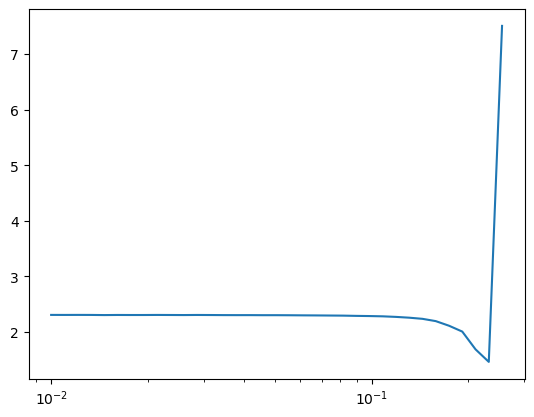

In [80]:
learn.fit(1)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

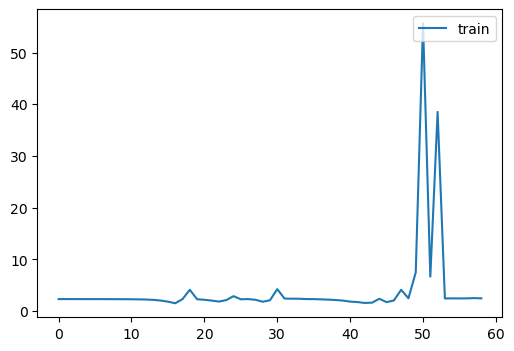

In [82]:
learn.fit(1)

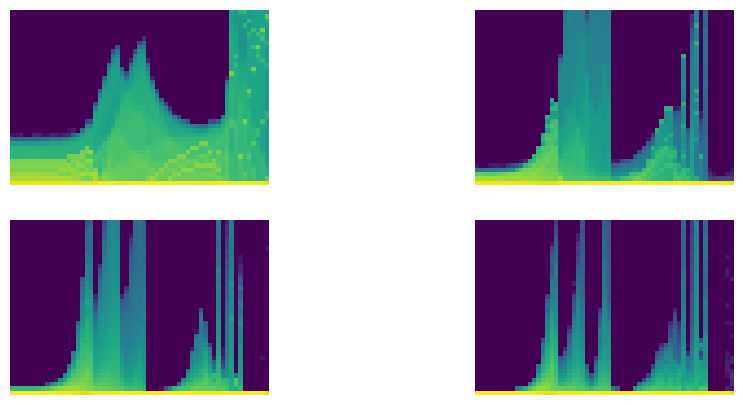

In [83]:
astats.color_dim()

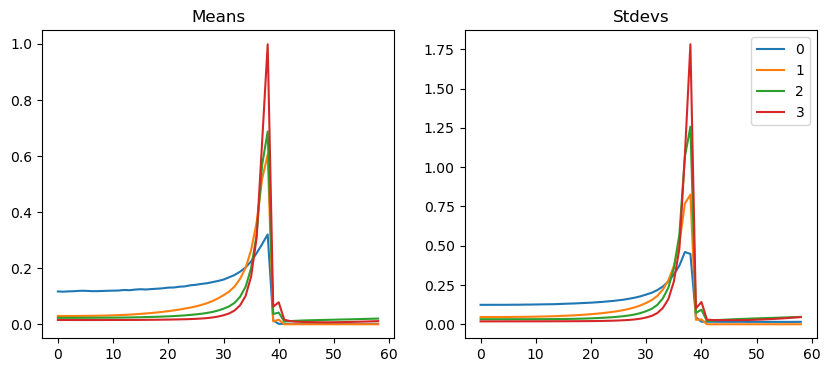

In [11]:
astats.plot_stats()

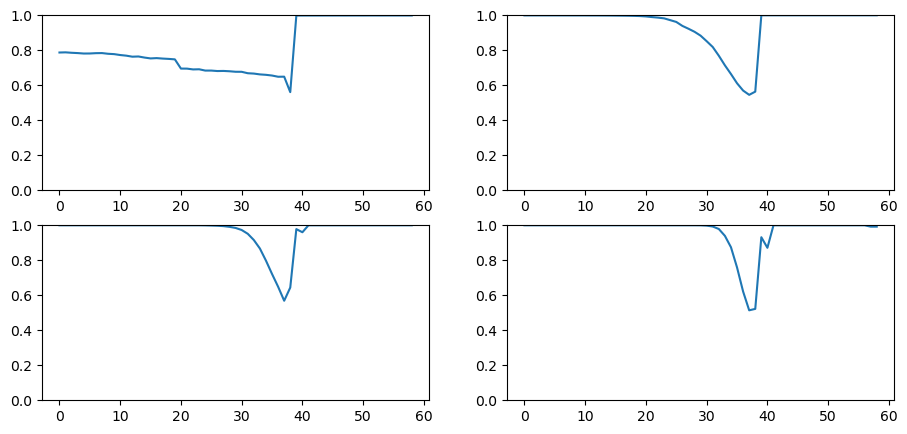

In [12]:
astats.dead_chart()

In [8]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [9]:
#|export
def clean_tb():
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [10]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

#### Initialization of weights

> Glorot/Xavier init --> scale inputs by $1/\sqrt{n_{in}}$, $n_{in}$ the number of inputs of a given layer. <br> 
It's ok for a network without non linearities but does not work to keep $\sigma^{2}\sim 1$, $\mu \sim 0$. It is quite obvious with relu that removes numbers below 0.

> Kaiming/He init --> scale inputs by $2/\sqrt{n_{in}}$, $n_{in}$ the number of inputs of a given layer. <br> 
Now the initialization allows to still pass information after several layers of depth.

_Note_ : Every torch module has the method apply that allows to apply a function to all the modules in the module. For instance, we can apply an init function.

In [11]:
model = get_model()
model.apply(lambda m:print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [12]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight)

In [13]:
model.apply(init_weights);        # apply returns the model, her we use ; to avoid printing the model after the prints

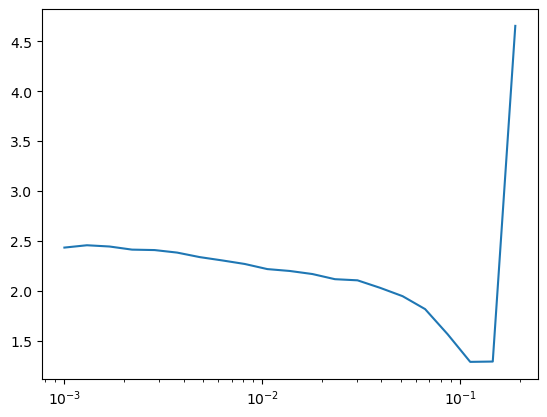

In [14]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-3, cbs=lrf_cbs)
learn.fit(1)

`model.apply(func)` returns the modified model, so we can use it like that:

In [15]:
set_seed(1)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

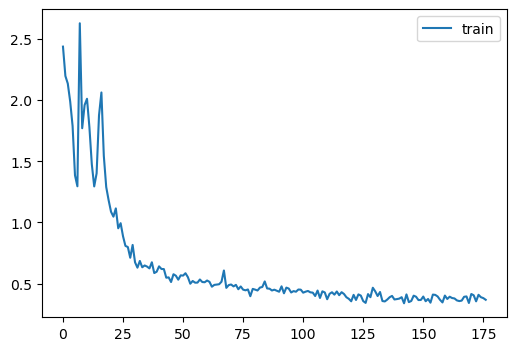

In [16]:
learn.fit(3)

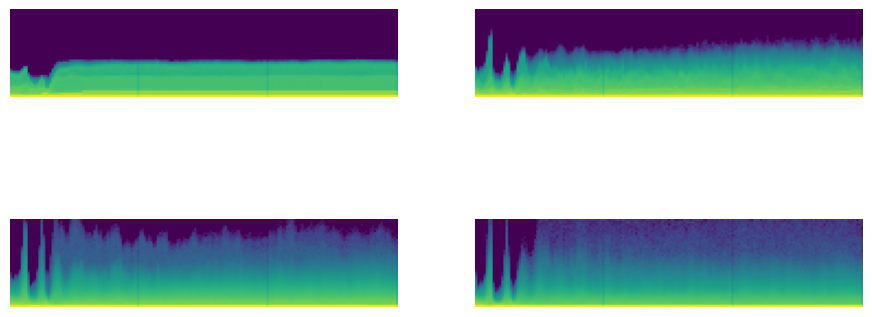

In [17]:
astats.color_dim()

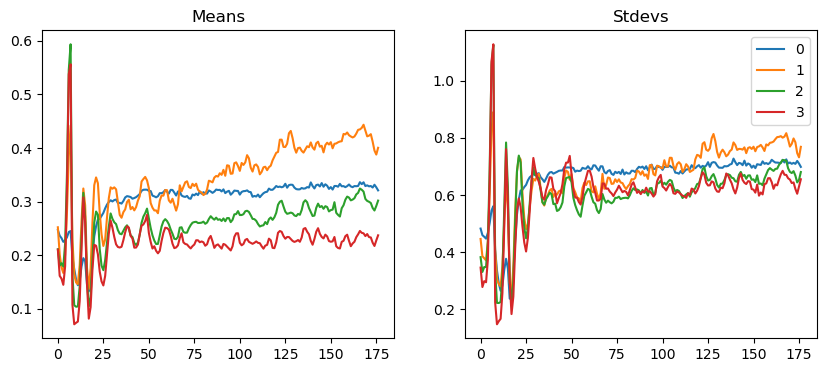

In [18]:
astats.plot_stats()

### Input normalization

It is much better but we still don't have a $\sigma^{2}\sim 1$, $\mu \sim 0$. The fact that the mean is not 0 is normal since in `astats = ActivationStats(fc.risinstance(nn.ReLU))` the stats are calculated after ReLU that has no value below 0. But $\sigma^{2}\sim 1$ should be attainable. <br>
It is probably related to the fact that the inputs are not normalized either, we can check on a batch:

In [19]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.28), tensor(0.35))

We can create a callback to do that.

In [20]:
#|export
class BatchTransformCB(Callback):
    def __init__(self, tfm): self.tfm = tfm
    def before_batch(self): self.learn.batch = self.tfm(self.learn.batch)

Assuming that the firs batch `xb` is representative of the statistics of the whole trainset, we can normalize with `xmean` and `xstd`:

In [21]:
def _norm(b): return (b[0]-xmean)/xstd, b[1]
norm = BatchTransformCB(_norm)

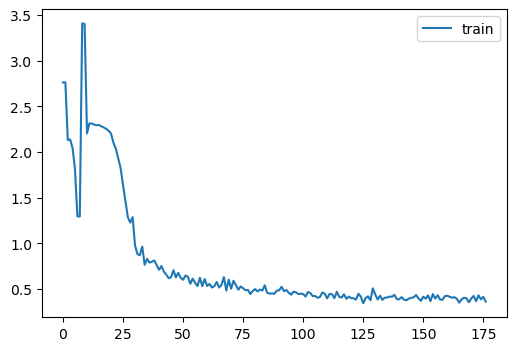

In [58]:
set_seed(1)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

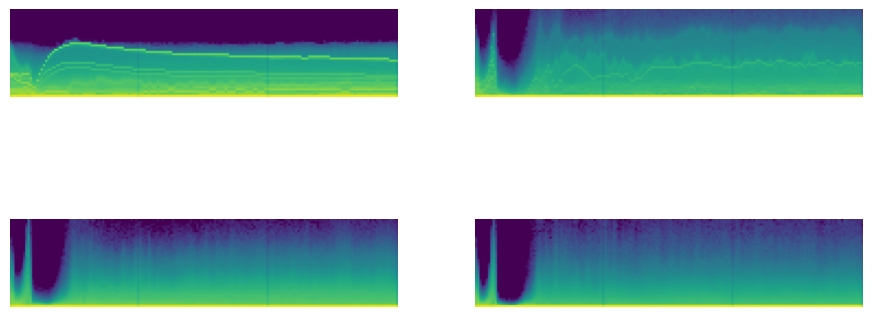

In [59]:
astats.color_dim()

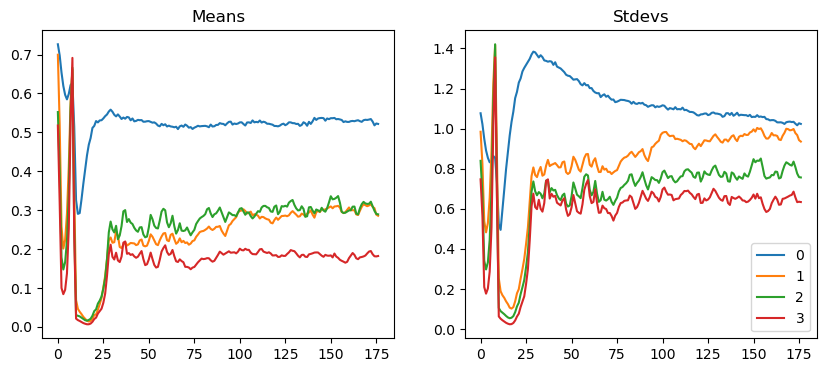

In [60]:
astats.plot_stats()

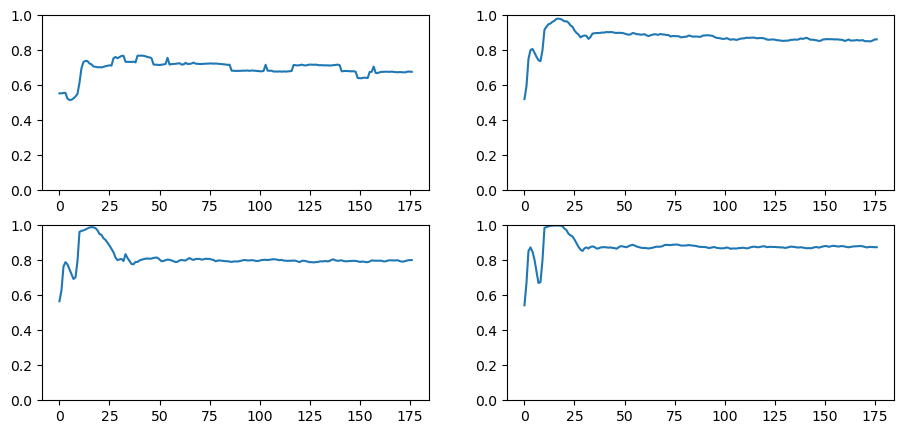

In [61]:
astats.dead_chart()

Very good, still some artefacts and non smooth behavior at the beginning and in the first two layers but it's much better than before.

Instead of using a callback we can also modify directly the data with the transformi function, and then rebuild the dataloader:

In [22]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

In [23]:
xb.mean(), xb.std()

(tensor(0.01), tensor(1.00))

We still have the problem of the positive mean due to ReLU. We can address that by modifying the ReLU activation function.

### General ReLU

In [24]:
#|export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [25]:
#|export
def plot_func(f, start=-5, end=5, steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

The couple of values `leak=0.1`, `sub=0.4` gives a mean of 0:

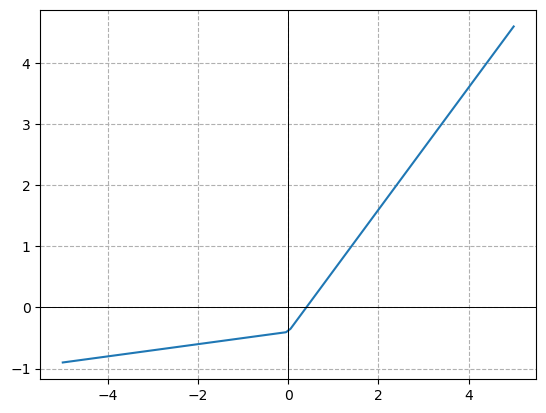

In [26]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [27]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [28]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

In [29]:
#|export
def init_weights(m, leaky=0):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [35]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [39]:
set_seed(1)
model = get_model(act_gr).apply(iw)

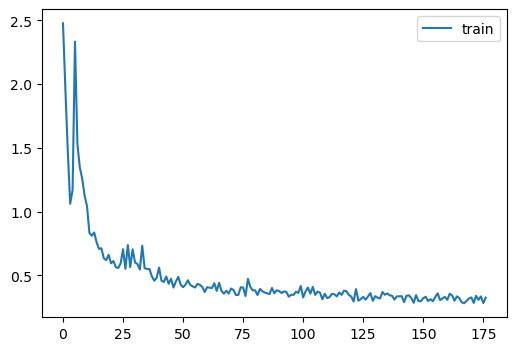

In [40]:
set_seed(1)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.17, cbs=cbs)
learn.fit(3)

In [41]:
len(astats)

4

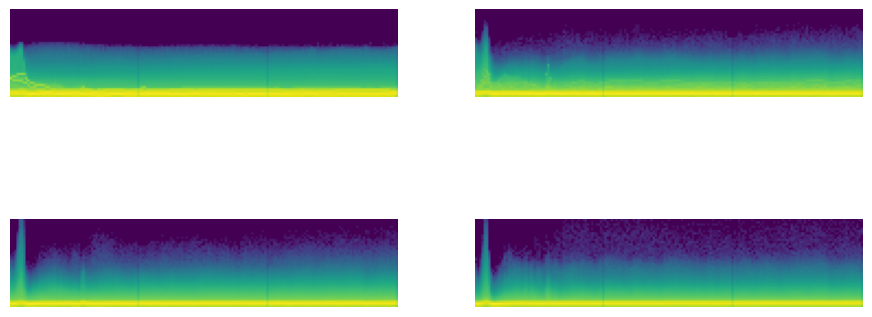

In [42]:
astats.color_dim()

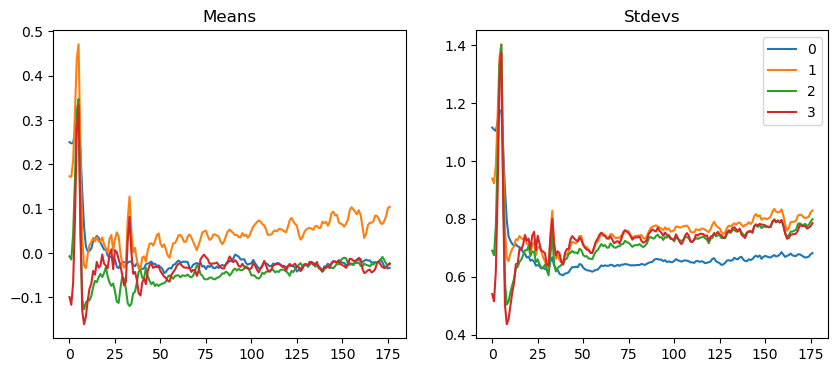

In [43]:
astats.plot_stats()

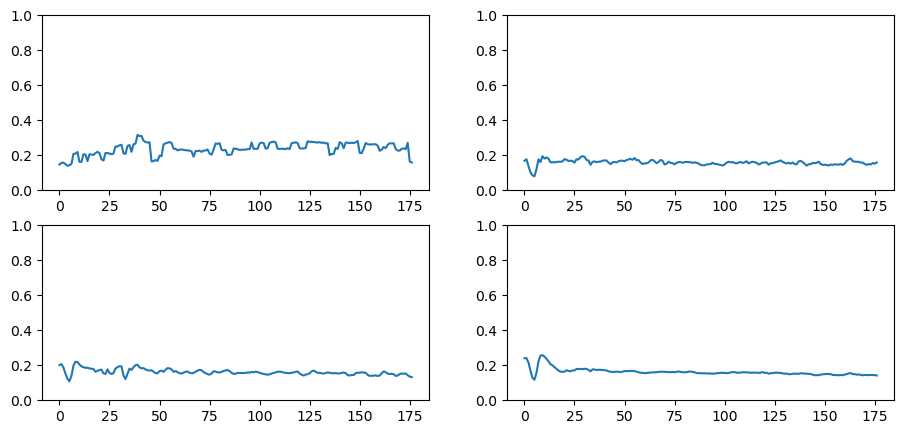

In [44]:
astats.dead_chart()

The result is very good, the proportion of dead activations (first bin corresponding to values between 0 and 0.25) is at 20% or below.

We can see that properly initializing the network's weights is very important and leads to a much better accuracy. We showed it for relu and general relu, but how can one find a good way to initialize the weights for any activation function?

### LSUV

In a paper called [All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf), the authors introduce *Layer-wise Sequential Unit-Variance* (*LSUV*), a generic way to initialize a model. <br>
The idea is to initialize the model as sees fit, then to pass through only one batch of the training set and calculate the mean and std. Then if the mean and std are too high, divide the weights by a bit and repeat until they get to $\sigma^{2}\sim 1$, $\mu \sim 0$. And then repeat the same process for all the layers.

We can use Hooks to implement this algorithm.

In the paper, the algorithm suggests that the initialization an orthonormal matrix initialization, Gaussian noise works but leads to slightly worse performance. And they adjust the variance of each conv layer:

In [54]:
#|export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m_in, xb):
    h = Hook(m_in, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std**2-1)>1e-3 or abs(h.mean)>1e-3):
            print('Initializing... ', h.mean, h.std)
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
        print('final: ', h.mean, h.std)
    print()
    h.remove()

In [55]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [56]:
set_seed(1)
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [57]:
for m in convs: lsuv_init(model, m, xb.to(def_device))

Initializing...  tensor(0.07) tensor(0.44)
Initializing...  tensor(0.01) tensor(0.96)
Initializing...  tensor(0.00) tensor(1.00)
final:  tensor(    0.00) tensor(1.00)

Initializing...  tensor(-0.04) tensor(0.38)
Initializing...  tensor(-0.05) tensor(0.99)
final:  tensor(-0.00) tensor(1.00)

Initializing...  tensor(-0.03) tensor(0.30)
Initializing...  tensor(-0.06) tensor(0.99)
Initializing...  tensor(-0.00) tensor(1.00)
final:  tensor(    -0.00) tensor(1.00)

Initializing...  tensor(0.02) tensor(0.32)
Initializing...  tensor(0.05) tensor(1.00)
final:  tensor(0.00) tensor(1.00)

Initializing...  tensor(-0.05) tensor(0.24)
Initializing...  tensor(-0.14) tensor(0.97)
Initializing...  tensor(-0.00) tensor(1.00)
final:  tensor(    -0.00) tensor(1.00)



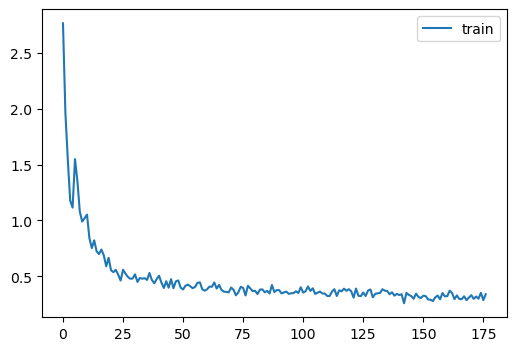

In [58]:
set_seed(1)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

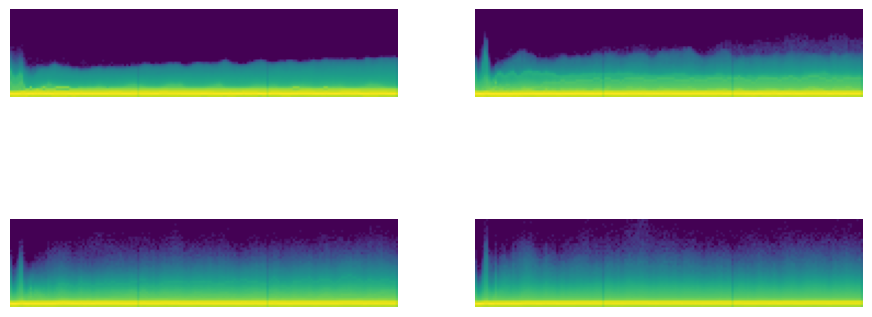

In [59]:
astats.color_dim()

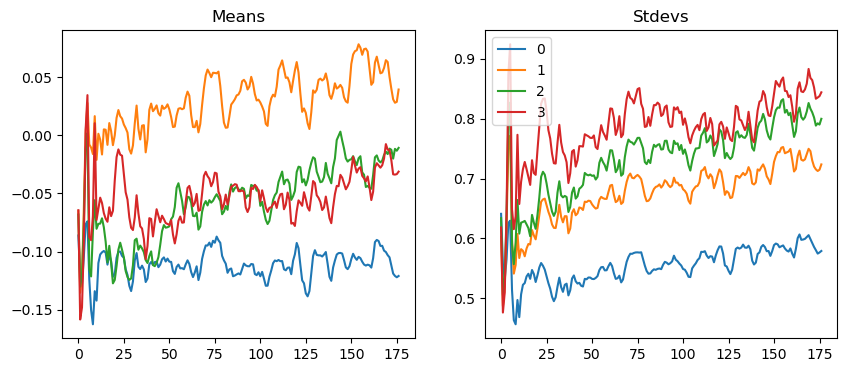

In [60]:
astats.plot_stats()

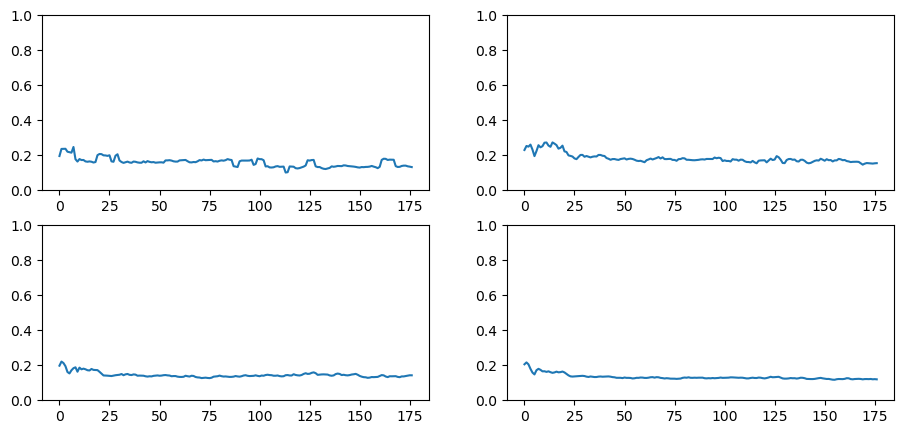

In [61]:
astats.dead_chart()

We can build a callback for the LSUV initialization. This LSUV version normalizes the outputs of the layer provided from the mean and std of its outputs, for a Conv2d layer: `mod_filter = fc.risinstance(nn.Conv2d)`.

In [73]:
#|export
class LSUVCallback(HooksCallback):
    def __init__(self, xb, mod_filter=fc.noop):
        self.wi_done = False
        self.xb = xb.to(def_device)
        super().__init__(_lsuv_stats, mod_filter)
    
    def before_fit(self):
        super().before_fit()
        for m, h in zip(self.mods, self.hooks): self.lsuv_init(m, h)
        self.wi_done = True
    
    def lsuv_init(self, m_in, h):
        with torch.no_grad():
            while self.learn.model(self.xb) is not None and (abs(h.std**2-1)>1e-3 or abs(h.mean)>1e-3):
                print('initializing... ', h.mean, h.std)
                m_in.bias -= h.mean
                m_in.weight.data /= h.std
            print('final: ', h.mean, h.std)
        print()
        h.remove()

In [99]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [100]:
lsuvcb = LSUVCallback(xb, fc.risinstance(nn.Conv2d))

In [101]:
metrics.order = 0

In [102]:
for c in cbs: c.order += 1

In [103]:
for c in cbs: print(c.order)

1
1
2
1


In [104]:
set_seed(1)
model = get_model(act_gr)

initializing...  tensor(0.07) tensor(0.44)
initializing...  tensor(0.01) tensor(0.96)
initializing...  tensor(0.00) tensor(1.00)
final:  tensor(    0.00) tensor(1.00)

initializing...  tensor(-0.04) tensor(0.38)
initializing...  tensor(-0.05) tensor(0.99)
final:  tensor(-0.00) tensor(1.00)

initializing...  tensor(-0.03) tensor(0.30)
initializing...  tensor(-0.06) tensor(0.99)
initializing...  tensor(-0.00) tensor(1.00)
final:  tensor(    -0.00) tensor(1.00)

initializing...  tensor(0.02) tensor(0.32)
initializing...  tensor(0.05) tensor(1.00)
final:  tensor(0.00) tensor(1.00)

initializing...  tensor(-0.05) tensor(0.24)
initializing...  tensor(-0.14) tensor(0.97)
initializing...  tensor(-0.00) tensor(1.00)
final:  tensor(    -0.00) tensor(1.00)



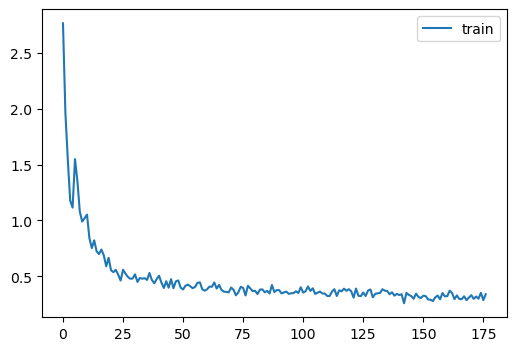

In [105]:
set_seed(1)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[lsuvcb])
learn.fit(3)

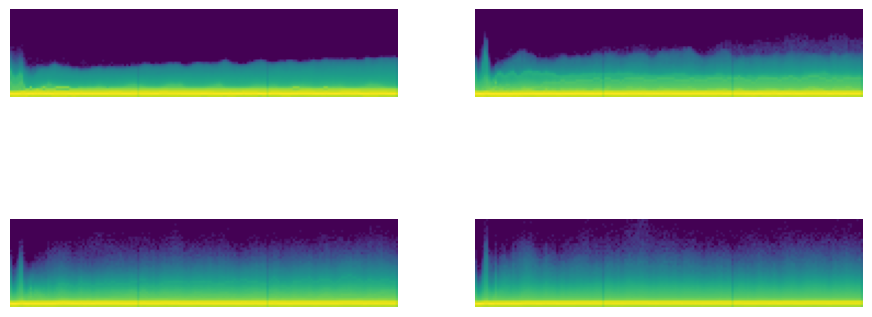

In [106]:
astats.color_dim()

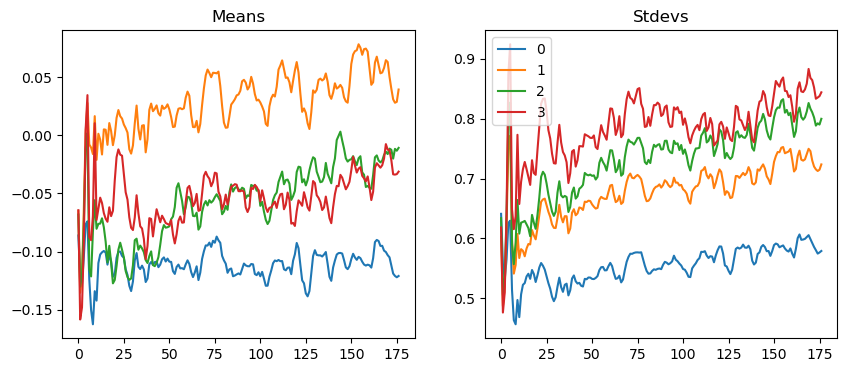

In [107]:
astats.plot_stats()

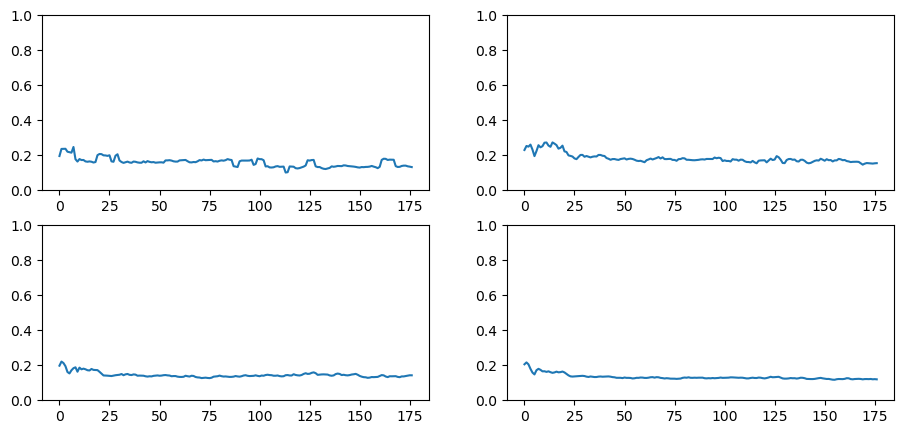

In [108]:
astats.dead_chart()

> We can try to increase the accuracy by reducing the batch size (more iterations) and then finetune with a lower learning rate: 

In [126]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

In [133]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [134]:
lsuvcb = LSUVCallback(xb, fc.risinstance(nn.Conv2d))

In [135]:
metrics.order = 0

In [136]:
for c in cbs: c.order += 1

In [137]:
set_seed(1)
model = get_model(act_gr)

initializing...  tensor(0.07) tensor(0.44)
initializing...  tensor(0.01) tensor(0.96)
initializing...  tensor(0.00) tensor(1.00)
final:  tensor(    0.00) tensor(1.00)

initializing...  tensor(-0.04) tensor(0.38)
initializing...  tensor(-0.05) tensor(0.99)
final:  tensor(-0.00) tensor(1.00)

initializing...  tensor(-0.03) tensor(0.30)
initializing...  tensor(-0.06) tensor(0.99)
initializing...  tensor(-0.00) tensor(1.00)
final:  tensor(    -0.00) tensor(1.00)

initializing...  tensor(0.02) tensor(0.32)
initializing...  tensor(0.05) tensor(1.00)
final:  tensor(0.00) tensor(1.00)

initializing...  tensor(-0.05) tensor(0.24)
initializing...  tensor(-0.14) tensor(0.97)
initializing...  tensor(-0.00) tensor(1.00)
final:  tensor(    -0.00) tensor(1.00)



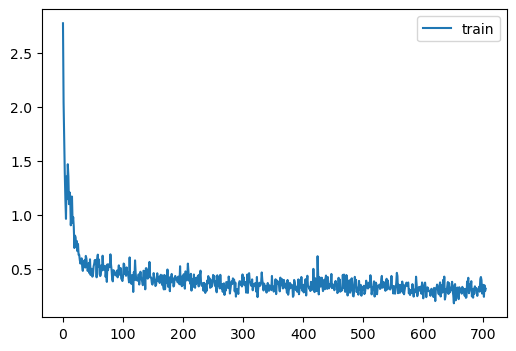

In [138]:
set_seed(1)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.19, cbs=cbs+[lsuvcb])
learn.fit(3)

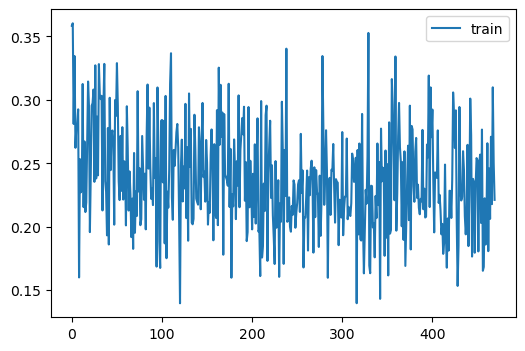

In [140]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

### Layer Normalization and Batch Normalization 

Both are normalization methods that are made part of the networks architecture. Batch Norm is described in the following paper ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167), and Layer Norm in this paper: ["Layer Normalization"](https://arxiv.org/abs/1607.06450).

#### LayerNorm

Layer Norm normalizes all the hidden units of a layer for a given exemple (in a NCHW batch it normalizes over Channels, Height and Width). The result is then linearly transformed by two learnable parameters `self.mult` and `self.add` to let the network adjust the degree of normalization it needs. Layer Norm is not only doing nornalization but it creates a displacement of the distribution that, depending on the test set, will make the flow of information more efficient.

In [45]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
    
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var((1,2,3), keepdim=True)
        x = (x-m)/(v+self.eps).sqrt()
        return x*self.mult + self.add

In [46]:
#|export 
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=True):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [47]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

In [157]:
dls = DataLoaders.from_dd(tds, 1024, num_workers=4)

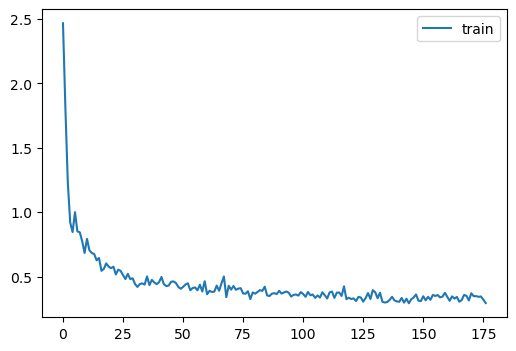

In [48]:
set_seed(1)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

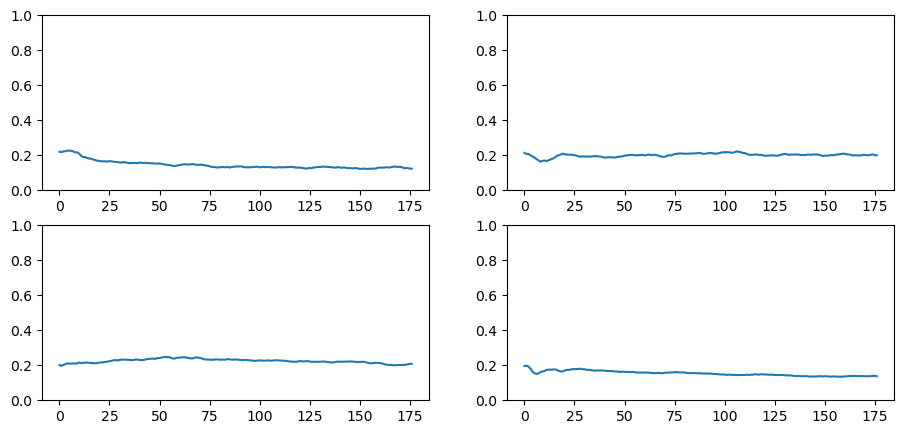

In [50]:
astats.dead_chart()

#### BatchNorm

In BatchNorm, we are not just subtracting the mean and the variance for each channel, for each batch, we are also keeping track of the previous means and variances of previous batches with an exponentially weighted moving average, with `self.means.lerp_`.<br>
The means and vars that batchnorm calculated are saved in the model with `register_buffer`. (This can be tricky later on if we want to do transfer learning.)

In [51]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

`lerp` is used to take a weighted average of two tensors, with a sliding scale:

In [56]:
torch.lerp(tensor(2.), tensor(10.), tensor(0.1))

tensor(2.80)

In [58]:
torch.lerp(tensor(2.), tensor(10.), tensor(0.7))

tensor(7.60)

With BatchNorm, the learning process is smoother, it allows us to increase the learning rate with no divergence problem: 

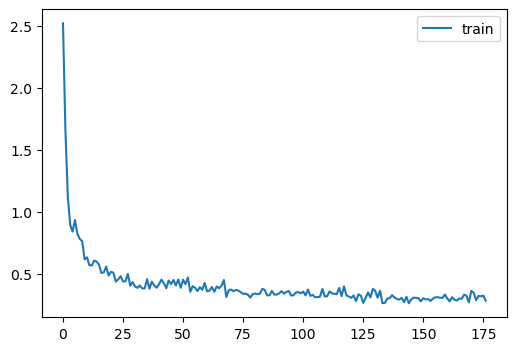

In [63]:
set_seed(1)
model = get_model(act_gr, norm=BatchNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

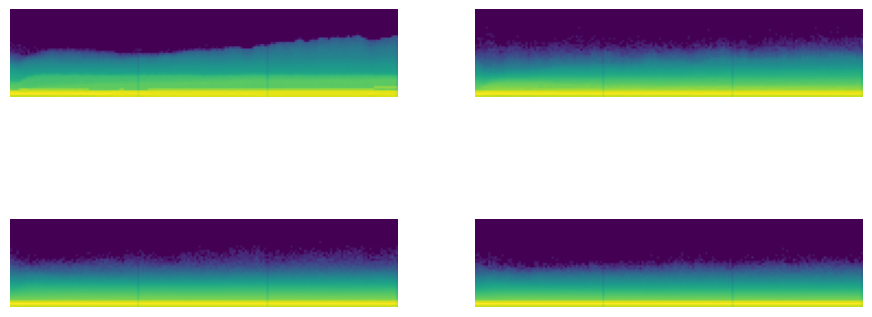

In [60]:
astats.color_dim()